#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [79]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [80]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv(path + "data01_train.csv")
test_data = pd.read_csv(path + "data01_test.csv")
features = pd.read_csv(path + "features.csv")

In [81]:
#불필요한 칼럼을 삭제하세요.
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [82]:
#전체 데이터의 행,열 개수 확인
print("train 데이터 크기 (행, 열):", train_data.shape)
print("test 데이터 크기 (행, 열):", test_data.shape)
print("features 데이터 크기 (행, 열):", features.shape)

train 데이터 크기 (행, 열): (5881, 562)
test 데이터 크기 (행, 열): (1471, 562)
features 데이터 크기 (행, 열): (561, 4)


In [83]:
#전체 데이터의 상위 5개 행 확인
print("train 데이터 :")
display(train_data.head(5))

print("\ntest 데이터 :")
display(test_data.head(5))

print("\nfeatures 데이터 :")
display(features.head(5))

train 데이터 :


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS



test 데이터 :


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING



features 데이터 :


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [84]:
#전체 데이터의 수치형 변수 분포 확인
print("train 데이터 (수치형):")
display(train_data.describe())

print("\ntest 데이터 (수치형):")
display(test_data.describe())

print("\nfeatures 데이터 (수치형):")
display(features.describe())

train 데이터 (수치형):


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000



test 데이터 (수치형):


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766



features 데이터 (수치형):


,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,"angle(Z,gravityMean)"
freq,79,126,76,1


In [85]:
#전체 데이터의 모든 변수 확인

# train 데이터의 정보 확인
print("train_df 정보:")
train_data.info()

# test 데이터의 정보 확인
print("\ntest_df 정보:")
test_data.info()

# Feature 데이터 정보 확인
print("\nFeature 데이터 정보:")
features.info()

train_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB

test_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB

Feature 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [86]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
static_actions = ['LAYING', 'SITTING', 'STANDING']
train_data['label1'] = train_data['Activity'].apply(lambda x: 0 if x in static_actions else 1)

### (2) x, y 분리

In [87]:
#x,y 분리하기
x = train_data.drop(columns=['Activity', 'label1'])
y = train_data['label1']

### (3) 데이터 분할
* train, val 분할

In [88]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=4420)

### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [89]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
bc_scaler = StandardScaler()
x_train = bc_scaler.fit_transform(x_train)
x_val = bc_scaler.transform(x_val)

y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [90]:
# 모델 설계
clear_session()
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)), # 입력층
    Dropout(0.3), # 과적합 방지
    Dense(64, activation='relu'),
    Dropout(0.2), # 과적합 방지
    Dense(1, activation='sigmoid')  # 출력층
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
# 컴파일 및 학습
model1.compile(loss='binary_crossentropy', optimizer=Adam(0.005), metrics=['accuracy'])
history1 = model1.fit(x_train, y_train, epochs=20, batch_size=64,
                      validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9570 - loss: 0.0775 - val_accuracy: 1.0000 - val_loss: 3.1464e-07
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 8.7647e-04 - val_accuracy: 1.0000 - val_loss: 2.9793e-08
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 8.7899e-10
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.5154e-06 - val_accuracy: 1.0000 - val_loss: 2.3976e-10
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.6393e-06 - val_accuracy: 1.0000 - val_loss: 2.6941e-10
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.1310e-07 - val_accuracy: 1.0000 - val_loss: 4.2391e-10
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.2859e-07 - val_accuracy: 1.0000 - val_loss: 4.0492e-10
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 -

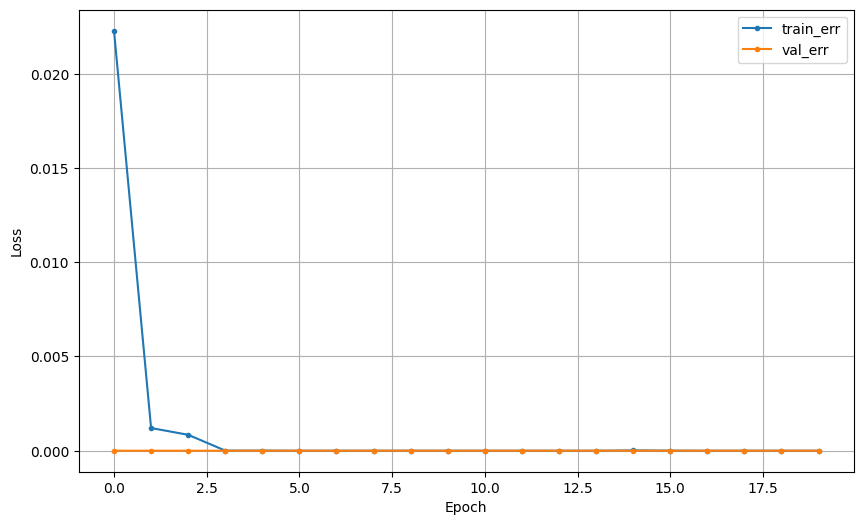

In [92]:
# 학습곡선
dl_history_plot(history1.history)

In [93]:
# 예측 및 평가
val_pred1 = (model1.predict(x_val) > 0.5).astype(int)
print(classification_report(y_val, val_pred1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       640
         1.0       1.00      1.00      1.00       537

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 2) 모델2

In [94]:
# 모델 설계
clear_session()
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
# 컴파일 및 학습
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, epochs=20, batch_size=64,
                      validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9734 - loss: 0.0904 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 5.8772e-04
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.8468e-04 - val_accuracy: 1.0000 - val_loss: 2.1438e-04
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.3675e-04 - val_accuracy: 1.0000 - val_loss: 1.0934e-04
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.8322e-04 - val_accuracy: 1.0000 - val_loss: 2.1706e-04
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.0883e-04 - val_accuracy: 1.0000 - val_loss: 6.3747e-05
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 8.7757e-05 - val_accuracy: 1.0000 - val_loss: 4.3576e-05
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - los

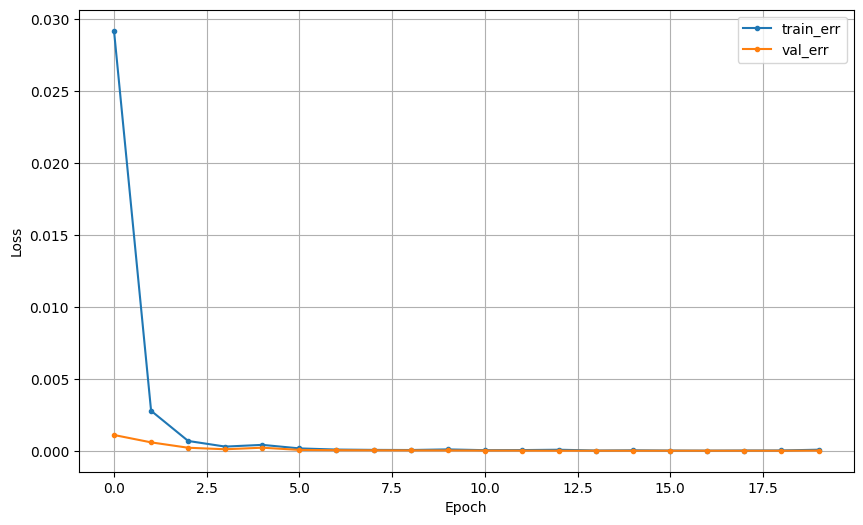

In [96]:
# 학습곡선
dl_history_plot(history2.history)


In [97]:
# 예측 및 평가
val_pred2 = (model2.predict(x_val) > 0.5).astype(int)
print(classification_report(y_val, val_pred2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       640
         1.0       1.00      1.00      1.00       537

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [101]:
# (tip) 정적 행동(0)인 데이터 추출
static = train_data[train_data['label1'] == 0].copy()

In [103]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
static_map = {'LAYING': 0, 'SITTING': 1, 'STANDING': 2}
static['label2'] = static['Activity'].map(static_map)

x_static = static.drop(columns=['Activity', 'label1', 'label2'])
y_static = static['label2']

x_st_train, x_st_val, y_st_train, y_st_val = train_test_split(
    x_static, y_static, test_size=0.2, random_state=42, stratify=y_static)

st_scaler = StandardScaler()
x_st_train = st_scaler.fit_transform(x_st_train)
x_st_val = st_scaler.transform(x_st_val)

In [104]:
# 모델 설계
clear_session()
static_model = Sequential([
    Dense(128, activation='relu', input_shape=(x_static.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
# 컴파일 및 학습
static_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
static_history = static_model.fit(x_st_train, y_st_train, epochs=20, batch_size=64,
                                  validation_data=(x_st_val, y_st_val), verbose=1)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6253 - loss: 0.8502 - val_accuracy: 0.8934 - val_loss: 0.2835
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9115 - loss: 0.2544 - val_accuracy: 0.9351 - val_loss: 0.1842
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9401 - loss: 0.1603 - val_accuracy: 0.9444 - val_loss: 0.1301
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9627 - loss: 0.0989 - val_accuracy: 0.9505 - val_loss: 0.1250
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9778 - loss: 0.0655 - val_accuracy: 0.9552 - val_loss: 0.1250
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9779 - loss: 0.0643 - val_accuracy: 0.9629 - val_loss: 0.1211
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9787 - loss: 0.0613 - val_accuracy: 0.9660 - val_loss: 0.0823
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9795 - loss: 0.0575 - val_accuracy: 0.9583 - val_loss

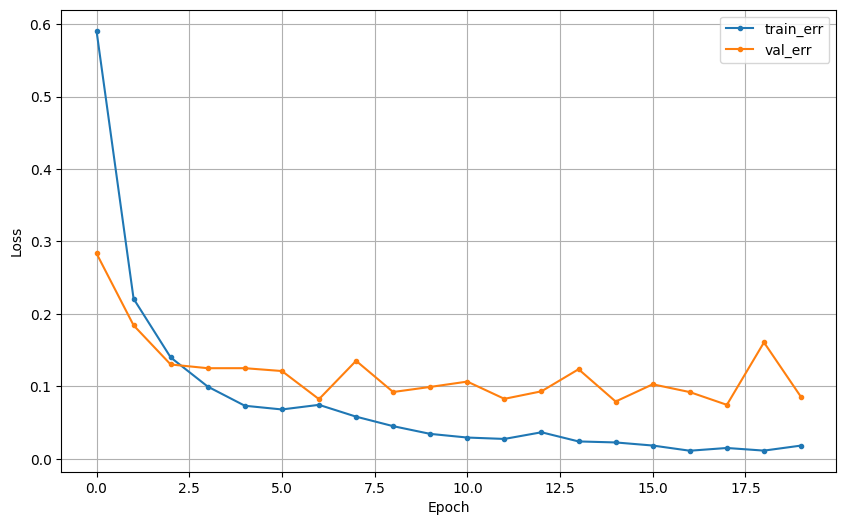

In [106]:
# 학습곡선
dl_history_plot(static_history.history)

In [107]:
# 예측 및 평가
y_static_pred = np.argmax(static_model.predict(x_st_val), axis=1)
print('ACC:', accuracy_score(y_st_val, y_static_pred))
print(classification_report(y_st_val, y_static_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
ACC: 0.9706336939721792
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       223
           1       0.96      0.96      0.96       206
           2       0.97      0.95      0.96       218

    accuracy                           0.97       647
   macro avg       0.97      0.97      0.97       647
weighted avg       0.97      0.97      0.97       647



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [112]:
# (tip) 동적 행동(1)인 데이터 추출
dynamic = train_data[train_data['label1'] == 1].copy()

In [113]:
# (tip) map 활용해서 숫자레이블로 매핑
dynamic_map = {'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2}
dynamic['label2'] = dynamic['Activity'].map(dynamic_map)

x_dynamic = dynamic.drop(columns=['Activity', 'label1', 'label2'])
y_dynamic = dynamic['label2']

x_dy_train, x_dy_val, y_dy_train, y_dy_val = train_test_split(
    x_dynamic, y_dynamic, test_size=0.2, random_state=42, stratify=y_dynamic)

dy_scaler = StandardScaler()
x_dy_train = dy_scaler.fit_transform(x_dy_train)
x_dy_val = dy_scaler.transform(x_dy_val)

In [114]:
# 모델 설계
clear_session()
dynamic_model = Sequential([
    Dense(128, activation='relu', input_shape=(x_dynamic.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [115]:
# 컴파일 및 학습
dynamic_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
dynamic_history = dynamic_model.fit(x_dy_train, y_dy_train, epochs=20, batch_size=64,
                                    validation_data=(x_dy_val, y_dy_val), verbose=1)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7264 - loss: 0.6542 - val_accuracy: 0.9774 - val_loss: 0.0698
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9836 - loss: 0.0553 - val_accuracy: 0.9925 - val_loss: 0.0317
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9919 - loss: 0.0259 - val_accuracy: 0.9962 - val_loss: 0.0205
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0108 - val_accuracy: 0.9962 - val_loss: 0.0201
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9996 - loss: 0.0059 - val_accuracy: 0.9962 - val_loss: 0.0141
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9990 - loss: 0.0093 - val_accuracy: 0.9962 - val_loss: 0.0129
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9996 - loss: 0.0051 - val_accuracy: 0.9925 - val_loss: 0.0180
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9988 - loss: 0.0075 - val_accuracy: 0.9943 - val_l

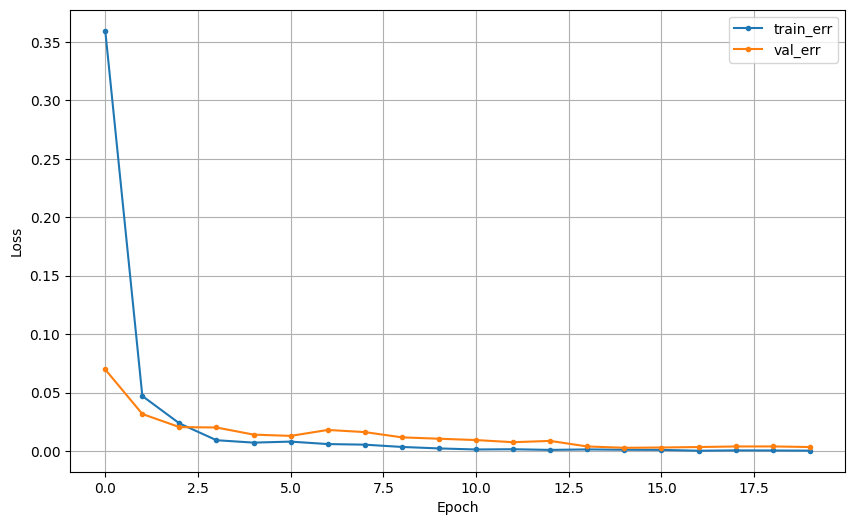

In [116]:
# 학습곡선
dl_history_plot(dynamic_history.history)

In [117]:
# 예측 및 평가
y_dynamic_pred = np.argmax(dynamic_model.predict(x_dy_val), axis=1)
print('ACC:', accuracy_score(y_dy_val, y_dynamic_pred))
print(classification_report(y_dy_val, y_dynamic_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
ACC: 0.9981132075471698
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       1.00      1.00      1.00       172
           2       0.99      1.00      1.00       158

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

#### 2) test 셋으로 예측하고 평가하기

In [119]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기
# 1. test_data 전처리
x_test_df = test_data.copy()
total_map = {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_UPSTAIRS': 4, 'WALKING_DOWNSTAIRS': 5}
x_test_df['label1'] = x_test_df['Activity'].map(total_map)

x_test = x_test_df.drop(columns=['Activity', 'label1'])
y_test = x_test_df['label1']

# bc_x_test 만들기
bc_x_test = bc_scaler.transform(x_test)
y_test = np.array(y_test)

# 2-1 단계1을 이용한 예측
pred1 = (model1.predict(bc_x_test) > 0.5).astype(int).squeeze()

x_st_test = x_test.loc[pred1 == 0, :]
x_dy_test = x_test.loc[pred1 == 1, :]

# 이후에 합치기 위한 index 저장
st_idx = x_st_test.index
dy_idx = x_dy_test.index

# 모델 2를 위한 전처리
x_st_test = st_scaler.transform(x_st_test)
x_dy_test = dy_scaler.transform(x_dy_test)

# 예측 결과 후처리
y_static_pred = np.argmax(static_model.predict(x_st_test), axis=1)
y_dynamic_pred = np.argmax(dynamic_model.predict(x_dy_test), axis=1) + 3

# 하나로 합치기
all_pred = pd.Series(index=x_test.index, dtype=int)
all_pred.loc[st_idx] = y_static_pred
all_pred.loc[dy_idx] = y_dynamic_pred

# 최종 성능 평가
acc = accuracy_score(y_test, all_pred)
print("Accuracy:", acc)
print(classification_report(y_test, all_pred))


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Accuracy: 0.9857239972807614
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.96      0.96      0.96       254
           2       0.98      0.97      0.97       287
           3       1.00      1.00      1.00       228
           4       1.00      1.00      1.00       215
           5       1.00      1.00      1.00       195

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471

